In [1]:
# 데이터 처리 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 라이브러리
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# 데이터 불러오는 라이브러리
from datasets import *

# 에빙하우스의 망각 곡선을 이용한 회귀 분석

[에빙하우스의 망각곡선 내용 바로가기](https://kangpro-safety.tistory.com/43)

망각 곡선을 이용한 회귀분석을 진행하기 위해 다음과 같은 방식으로 진행하였다.

망각 곡선의 간략식은 다음과 같다.<br/>

$ R(t) = R_0e^{-kt} $
- $R(t)$ : 시간 t초 후 기억 유지율
- $R_0$ : 초기 기억수준
- $k$ : 망각 속도 계수
- $t$ : 시간

---
## 1. 시작하기 앞서

위의 방정식을 이용하기 전 데이터 EDA를 통해서 알 수 있는 부분은 다음과 같다.
- 각 유저 개인이 컨텐츠를 시작하고 완료하기 까지 걸린 시간
- 각 유저 개인이 레슨을 시작하고 완료하기 까지 걸린 시간

그리고 데이터EDA를 했음에도 알 수 없는 내용은 다음과 같았다.
- 교육 플랫폼이 어떤 교육을 기반으로 운영하고 있는지

---
## 2. 망각 속도 계수 함수 정의

에빙하우스의 망각 곡선 방정식에서 구할 수 있는 상수는 **망각 속도 계수** $k$로 지정하였다.<br/>
다른 상수를 구할 수 없는 이유는 다음과 같다.
- 초기 기억수준($R_0$)은 유저의 학습 후 테스트(시험)에 대한 데이터가 있어야 진행할 수 있는데 데이터가 존재하지 않아 사용할 수 없다.
- 시간($t$)은 우리가 사용하고자 하는 총 걸린 시간을 이야기 하는 것이 아닌, 시간이 지남에 따른 연속적인 수치를 사용하므로, 값이 하나인 것에는 대응하기 어려울 수 있다고 생각한다.

In [2]:
# 망각 곡선 모델 정의
def forgetting_curve(I, k0, alpha):
    return k0 * np.exp(-alpha * I)

망각 속도 계수를 구하는 방정식(모델)은 다음과 같이 정의할 수 있다.

$k = k_0e^{-\alpha I}$

1. $k_0$ : **기본 망각 계수**
    - 앞서 이야기한 교육 플랫폼이 어떤 교육을 기반으로 운영되고 있는지 데이터로 확인할 수 없었다.
    - 각 컨텐츠 소비 시간 패턴인 학습 집중도 비율값인 $I$를 통해 해당 플랫폼이 어떤 교육을 기반으로 하는지 파악할 수 있다.

In [3]:
# 학습 집중도 비율
def LCR(T_L,  T_C):
    return T_L / T_C

2. $I = \frac {T_L} {T_C}$ : 학습 집중도 비율
    - $I \approx 1.0$ (거의 모든 시간을 레슨에 소비) → 집중 학습
    - $I < 1.0$ (일부만 레슨 학습) → 실습 위주 학습 가능성
        - $I \approx 0.5$ (절반만 레슨 학습)
        - $I \approx 0.2$ (짧은 시간만 레슨 학습)
    
    이 값을 각 유저 개인마다 계산하여 다음과 같은 절차를 거친다.
    1. K-means 으로 군집화를 통한 Clustering 적용
    2. 클러스터를 분석하여 높은 $I$ 그룹이 실제 암기/개념 학습인지 검증<br/>
        → 검증은 어떻게?

        - 복습 빈도
            - 암기/개념 이해 학습의 경우 짧은 간격으로 반복 학습하고, 같은 콘텐츠를 여러 번 조회
            - 실습 학습의 경우 처음 학습 후 재방문이 적다. (즉 위의 말과 반대된다.)

        - 콘텐츠 재방문 시간 간격
            - Ebbinghaus 망각 곡선 이론에 따르면, 복습 패턴은 학습 유형과 관련이 있다.
            - 복습이 빠르게 이루어지면 암기 가능성, 복습 없이 실습이 많다면 실습 가능성

위의 내용을 통해 $k_0$값을 실제 데이터와 잘 맞게 하기 위해 다음과 같은 함수식을 사용하였다.

In [4]:
# 기본적인 망각 계수
def k0_exponential(I):
    return 0.3 - 0.2 * np.exp(-3 * I)

3. $\alpha$ : 학습 집중도에 따른 망각 속도 감소 계수<br/>
    위의 학습 집중도 비율을 통해 Clustering한 군집들에 대해서 다음과 같은 값을 적용
    - $I = 1.0$ → 3.0
    - $I = 0$ → 1.5

여기서 $\alpha$값을 실제 학습 과정에서 $\alpha$ 변화를 현실적인 패턴을  반영하기 위해 다음과 같은 함수식을 작성하였다.

In [5]:
# 학습 집중도에 따른 망각 속도 감소 계수
def alpha_exponential(number):
    return 3.0 - 1.5 * np.exp(-3 * number)

---
## 3. 데이터 전처리 및 데이터 준비

In [6]:
start_content_df = start.content()
end_content_df = end.content()
#--------------------------------------#
enter_lesson_page_df = enter.lesson_page()
complete_lesson_df = complete.lesson()

e:\Visual Studio Code\codeit\intermediate_project\datasets.py:132: DtypeWarning: Columns (9,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [7]:
content_difficulty = start_content_df[['content.id', 'content.difficulty']]

In [9]:
content_difficulty.drop_duplicates(subset='content.id', keep='last', inplace=True)

C:\Users\lento\AppData\Local\Temp\ipykernel_23068\541073857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_difficulty.drop_duplicates(subset='content.id', keep='last', inplace=True)


In [10]:
content_difficulty

,content.id,content.difficulty
3374,ebd394bf186858e4b48ec05b539f7cc5,intermediate
14612,d4466fc8e5fb21a89472b25addf369a5,advanced
18351,16c90877db6d303e295cb27e74f55050,intermediate
21578,177bd0dc4f121eef0bb24ad0d23541b6,intermediate
41870,894feacdc6903755e229b3418c3212f6,advanced
...,...,...
124912,f64c475280676531a31f2f8e0648599c,intermediate
124913,68a3658f1b936bfff3bd6960cd561b0a,beginner
124914,621c7ad99b17d2d16832b618d47aea7e,advanced
124915,61b6463287573f00de13a930805a52d6,beginner


In [ ]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'content.difficulty' 열을 숫자로 변환 
content_difficulty['content.difficulty'] = label_encoder.fit_transform(content_difficulty['content.difficulty'])

# 'content.difficulty' 열을 int8로 변환하여 메모리 절약
content_difficulty['content.difficulty'] = content_difficulty['content.difficulty'].astype('int8')

# 결과 확인
content_difficulty[['content.difficulty']].head()

C:\Users\lento\AppData\Local\Temp\ipykernel_23068\845457250.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_difficulty['content.difficulty'] = label_encoder.fit_transform(content_difficulty['content.difficulty'])
C:\Users\lento\AppData\Local\Temp\ipykernel_23068\845457250.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_difficulty['content.difficulty'] = content_difficulty['content.difficulty'].astype('int8')


,content.difficulty
3374,3
14612,0
18351,3
21578,3
41870,0


In [12]:
def merge_data(data1, data2):
    for data in [data1, data2]:
        data['client_event_time'] = pd.to_datetime(data['client_event_time'])
    
    if 'lesson.id' in data1.columns:
        merged_data = pd.merge(
            data1[['user_id', 'content.id', 'lesson.id', 'client_event_time']],
            data2[['user_id', 'content.id', 'lesson.id', 'client_event_time']],
            how='outer',
            on=['user_id', 'content.id', 'lesson.id'],
            suffixes=('_start', '_end')
        )

        merged_data['time_diff'] = (merged_data['client_event_time_end'] - merged_data['client_event_time_start']).dt.total_seconds()

    else:
        merged_data = pd.merge(
            data1[['user_id', 'content.id', 'client_event_time']],
            data2[['user_id', 'content.id', 'client_event_time']],
            how='outer',
            on=['user_id', 'content.id'],
            suffixes=('_start', '_end')
        )

        merged_data['time_diff'] = (merged_data['client_event_time_end'] - merged_data['client_event_time_start']).dt.total_seconds()

    return merged_data


In [13]:
content_merged_df = merge_data(start_content_df, end_content_df)

In [14]:
content_merged_df.dropna(inplace=True)

In [15]:
content_merged_groupby = content_merged_df.groupby('content.id').agg(
    avg_spend_time = ('time_diff', 'mean')
).reset_index()

In [16]:
del content_merged_df

In [17]:
del start_content_df, end_content_df

In [18]:
content_merged_groupby

,content.id,avg_spend_time
0,03b4a290c08f7fa83933827a994f2e61,6.604980e+05
1,0ab2b890d4068c1490b89676773256f6,1.360643e+06
2,101e1d0dcc38d9c86156f008a145083e,1.360233e+06
3,123715e9b63b3efb32cdcd947ea96aaf,1.042258e+06
4,165def8885b8a2ec0c92404048d7e345,1.328978e+06
...,...,...
109,f6f082e10dc9c1061cb809989b361d9c,1.391302e+06
110,f8b0ca043f5f0437603142ae93e6a424,1.606831e+06
111,fc3051206e08a57bc14fa52a7eec904b,3.819803e+05
112,fc6a9e04f693ea724c55153d1ae82c65,2.928410e+03


학습 시간의 계산이 되는 114개의 컨텐츠를 대상으로 학습 집중도 비율을 분석

In [19]:
lesson_merged_df = merge_data(enter_lesson_page_df, complete_lesson_df)
lesson_merged_df = lesson_merged_df[lesson_merged_df['content.id'].isin(content_merged_groupby['content.id'].unique())]
lesson_merged_df = lesson_merged_df.dropna(subset='user_id')
lesson_merged_df = lesson_merged_df[lesson_merged_df['client_event_time_start'] < lesson_merged_df['client_event_time_end']]
lesson_merged_df = lesson_merged_df[(lesson_merged_df['time_diff'] > 60) & (lesson_merged_df['time_diff'] <= 86400)]
lesson_merged_df = lesson_merged_df.drop_duplicates(subset=['user_id', 'content.id', 'lesson.id'], keep='last')

In [20]:
del enter_lesson_page_df, complete_lesson_df

In [21]:
lesson_merged_df.head(50)

,user_id,content.id,lesson.id,client_event_time_start,client_event_time_end,time_diff
1,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,0cf175a1781a8e0020bf6c6bdc80e78a,2023-03-18 15:46:47.244,2023-03-18 15:51:34.713,287.469
3,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,1e2a48ce24bce72e7d36da219ee9d254,2023-03-18 16:23:13.225,2023-03-18 16:29:04.507,351.282
8,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,3ae4d4504b620370687e58e0a33cf22d,2023-03-18 16:18:30.963,2023-03-18 16:23:11.315,280.352
12,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,4d65e0729706704bf34953f2613d6ecd,2023-03-18 15:52:16.017,2023-03-18 15:53:48.730,92.713
25,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,58a55a039ef52567cfe0821f92b3c9e6,2023-03-18 14:33:22.636,2023-03-18 16:48:55.626,8132.990
33,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,adfe4e8b1dc5d9f2e4b76e4bc8ee221c,2023-03-18 16:39:05.326,2023-03-18 16:42:42.220,216.894
36,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,bc72ce5b1d619166b28d2e990f8d9f49,2023-03-18 16:29:06.499,2023-03-18 16:34:52.258,345.759
38,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,c84ce096d3407c9ce4eebd380df44dbf,2023-03-18 16:04:56.615,2023-03-18 16:18:28.265,811.650
42,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,ce99776e0779bc82754a1fc8bfb719d1,2023-03-18 15:54:11.764,2023-03-18 16:00:32.081,380.317
44,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,eb40ff18855f20f7cd2d55dbc48b49ae,2023-03-18 16:00:34.488,2023-03-18 16:04:54.296,259.808


In [22]:
lesson_groupby = lesson_merged_df.groupby(['user_id', 'content.id']).agg(
    total_spend_time = ('time_diff', 'sum')
).reset_index()

In [23]:
del lesson_merged_df

In [24]:
lesson_groupby.head(50)

,user_id,content.id,total_spend_time
0,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,11375.425
1,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,80455.985
2,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,80627.778
3,000087537cbfd934375364218ff10f91,0ab2b890d4068c1490b89676773256f6,2670.409
4,000087537cbfd934375364218ff10f91,61b6463287573f00de13a930805a52d6,2190.698
5,0001f15911b404f3bf5b8571afafa4e4,61b6463287573f00de13a930805a52d6,1173.352
6,0001f15911b404f3bf5b8571afafa4e4,c8e53577758bf66711094352a5abd8c3,3763.218
7,0001f15911b404f3bf5b8571afafa4e4,f4be1a0fe0e301b03115591777fddf29,448.283
8,0003c0ede663b9e3b55d9dc3f7e8690f,18992b667be06d6f29ba0008f99d9745,100102.700
9,0003c0ede663b9e3b55d9dc3f7e8690f,289ae01387d36327c04b176c6d62a626,103478.721


In [25]:
tmp = lesson_groupby.merge(content_merged_groupby, how='inner', on='content.id')

tmp['LCR'] = LCR(tmp['total_spend_time'], tmp['avg_spend_time'])
tmp['k0_exponential'] = k0_exponential(tmp['LCR'])
tmp['alpha_exponential'] = alpha_exponential(tmp['LCR'])
tmp['forgetting_curve'] = forgetting_curve(tmp['LCR'], tmp['k0_exponential'], tmp['alpha_exponential'])

tmp = tmp[tmp['LCR'] < 1.5]

In [26]:
del lesson_groupby, content_merged_groupby

In [27]:
tmp = tmp[['user_id', 'content.id', 'forgetting_curve']]

In [28]:
tmp = pd.merge(
    tmp,
    content_difficulty,
    how='inner',
    on='content.id'
)

In [ ]:
tmp

,user_id,content.id,forgetting_curve,content.difficulty
0,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,0.106390,1
1,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,0.119298,3
2,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,0.127006,1
3,000087537cbfd934375364218ff10f91,0ab2b890d4068c1490b89676773256f6,0.100875,3
4,000087537cbfd934375364218ff10f91,61b6463287573f00de13a930805a52d6,0.101307,1
...,...,...,...,...
184461,fffe529de03d6187ef7ed765650c8d2b,f491517f4737a60d661cd1fcacc702c0,0.125845,3
184462,fffe529de03d6187ef7ed765650c8d2b,f4be1a0fe0e301b03115591777fddf29,0.104702,1
184463,fffe529de03d6187ef7ed765650c8d2b,f64c475280676531a31f2f8e0648599c,0.101642,3
184464,fffe529de03d6187ef7ed765650c8d2b,f6f082e10dc9c1061cb809989b361d9c,0.127042,3


회귀 계수: [[0.00044044]]
절편: [0.10871379]
Mean Squared Error: 0.00011083550023800444


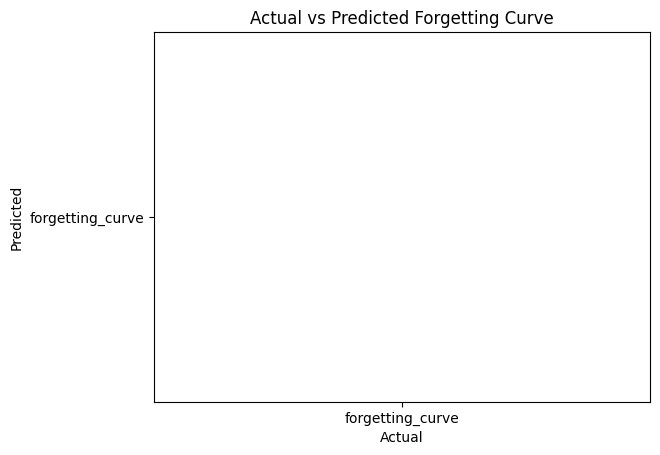

In [35]:
# 독립 변수(X)와 종속 변수(y)
X = tmp[['content.difficulty']]  # 독립 변수
y = tmp[['forgetting_curve']]  # 종속 변수

# 데이터 분할 (훈련용/테스트용 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 회귀 분석 결과 출력
print("회귀 계수:", model.coef_)
print("절편:", model.intercept_)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# 예측 결과와 실제 결과 비교 (시각화)
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Forgetting Curve")
plt.show()

In [36]:
# 예시 데이터 (이미 구한 데이터로 대체 가능)
# 독립 변수(X)와 종속 변수(y)
X = tmp[['content.difficulty']]  # 독립 변수
y = tmp[['forgetting_curve']]  # 종속 변수

# statsmodels에서는 독립변수에 상수항(절편)을 추가해야 함
X = sm.add_constant(X)  # 상수항 추가

# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 분석 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       forgetting_curve   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     502.2
Date:                Wed, 12 Mar 2025   Prob (F-statistic):          4.48e-111
Time:                        19:27:26   Log-Likelihood:             5.7623e+05
No. Observations:              184466   AIC:                        -1.152e+06
Df Residuals:                  184464   BIC:                        -1.152e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1087    3.8

최적화된 k0: 0.10822838247725496
최적화된 alpha: -0.2213465757231981


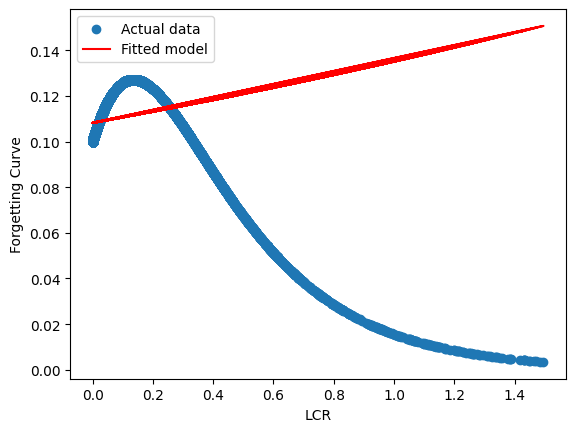

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 비선형 모델 정의
def forgetting_curve_model(LCR, k0, alpha):
    return k0 * np.exp(-alpha * LCR)

# 독립 변수 (LCR, k0_exponential, alpha_exponential)
X = np.column_stack((tmp['LCR'], tmp['k0_exponential'], tmp['alpha_exponential']))

# 종속 변수 (forgetting_curve)
y = tmp['forgetting_curve']

# curve_fit을 사용하여 파라미터 최적화
popt, pcov = curve_fit(forgetting_curve_model, X[:, 0], y, p0=[0.1, 0.1])

# 최적화된 파라미터 (k0, alpha)
k0_opt, alpha_opt = popt

print("최적화된 k0:", k0_opt)
print("최적화된 alpha:", alpha_opt)

# 모델의 예측 값 계산
y_pred = forgetting_curve_model(X[:, 0], k0_opt, alpha_opt)

# 결과 시각화
plt.scatter(X[:, 0], y, label='Actual data')
plt.plot(X[:, 0], y_pred, label='Fitted model', color='red')
plt.xlabel('LCR')
plt.ylabel('Forgetting Curve')
plt.legend()
plt.show()

In [ ]:
print("first_paid_enter_lesson 컬럼 목록:", first_paid_enter_lesson.columns.tolist())
print("first_paid_complete_lesson 컬럼 목록:", first_paid_complete_lesson.columns.tolist())


first_paid_enter_lesson 컬럼 목록: ['enter_lesson_time', 'event_type', 'user_id', 'content_id', 'is_trial', 'lesson_id']
first_paid_complete_lesson 컬럼 목록: ['city', 'complete_lesson_time', 'country', 'device_type', 'event_type', 'language', 'os_name', 'user_id', 'content_id', 'lesson_id', 'time_diff_seconds', 'complete_lesson_time_trimmed']


In [ ]:
# enter_df
enter_df = first_paid_enter_lesson.drop(columns=['is_trial'])
enter_df = enter_df.rename(columns={'enter_lesson_time': 'event_time'})

# complete_df 
complete_df = first_paid_complete_lesson.drop(columns=['city', 'country', 'device_type', 'language', 'os_name', 'time_diff_seconds','complete_lesson_time_trimmed'])
complete_df = complete_df.rename(columns={'complete_lesson_time': 'event_time'})

print(enter_df.head())
print(complete_df.head())



                   event_time         event_type  \
16137 2023-03-18 19:37:05.778  enter.lesson_page   
16138 2023-03-18 19:42:48.654  enter.lesson_page   
16139 2023-03-18 19:46:07.383  enter.lesson_page   
16140 2023-03-18 19:51:40.154  enter.lesson_page   
16141 2023-03-18 19:53:41.558  enter.lesson_page   

                                user_id                        content_id  \
16137  0000572f2ba8079bcefd2760b632e820  61b6463287573f00de13a930805a52d6   
16138  0000572f2ba8079bcefd2760b632e820  61b6463287573f00de13a930805a52d6   
16139  0000572f2ba8079bcefd2760b632e820  61b6463287573f00de13a930805a52d6   
16140  0000572f2ba8079bcefd2760b632e820  61b6463287573f00de13a930805a52d6   
16141  0000572f2ba8079bcefd2760b632e820  61b6463287573f00de13a930805a52d6   

                              lesson_id  
16137  db421b66bfd27eccd0e862e30b4de1be  
16138  09c8a2d29087cb3d47823acb5f2705e3  
16139  b734f43b5123f8bdbf7d8f865bd3eacf  
16140  6e3afbeb4942c6c29038321e5995f4f1  
16141  70cb48c

In [ ]:
import pandas as pd

# 데이터프레임을 chunk 단위로 처리하는 함수
def process_in_chunks(enter_df, complete_df, chunksize=10000):
    # event_type 추가
    enter_df['event_type'] = 'enter'
    complete_df['event_type'] = 'complete'

    # 병합할 데이터를 chunk 단위로 나눔
    enter_chunks = [enter_df[i:i+chunksize] for i in range(0, len(enter_df), chunksize)]
    complete_chunks = [complete_df[i:i+chunksize] for i in range(0, len(complete_df), chunksize)]

    merged_chunks = []

    for enter_chunk, complete_chunk in zip(enter_chunks, complete_chunks):
        # 개별 chunk 병합
        chunk_merged = pd.concat([enter_chunk, complete_chunk], ignore_index=True)
        
        # 정렬 수행
        chunk_merged = chunk_merged.sort_values(by=['user_id', 'content_id', 'lesson_id', 'event_time'])

        # 결과 저장
        merged_chunks.append(chunk_merged)

    # 모든 chunk를 다시 합쳐 최종 데이터프레임 생성
    final_df = pd.concat(merged_chunks, ignore_index=True)
    
    return final_df

# 함수 실행
merged_df = process_in_chunks(enter_df, complete_df, chunksize=10000)

# 결과 확인
print(merged_df.head())


               event_time event_type                           user_id  \
0 2023-03-18 19:42:48.654      enter  0000572f2ba8079bcefd2760b632e820   
1 2023-03-19 00:46:47.244      enter  0000572f2ba8079bcefd2760b632e820   
2 2023-03-19 00:51:34.741      enter  0000572f2ba8079bcefd2760b632e820   
3 2023-03-19 01:29:04.118      enter  0000572f2ba8079bcefd2760b632e820   
4 2023-03-19 01:29:04.507   complete  0000572f2ba8079bcefd2760b632e820   

                         content_id                         lesson_id  
0  61b6463287573f00de13a930805a52d6  09c8a2d29087cb3d47823acb5f2705e3  
1  61b6463287573f00de13a930805a52d6  0cf175a1781a8e0020bf6c6bdc80e78a  
2  61b6463287573f00de13a930805a52d6  0cf175a1781a8e0020bf6c6bdc80e78a  
3  61b6463287573f00de13a930805a52d6  1e2a48ce24bce72e7d36da219ee9d254  
4  61b6463287573f00de13a930805a52d6  1e2a48ce24bce72e7d36da219ee9d254  


### 4-1. 첫 결제에서 활동.비활동 유저 찾기

In [ ]:
# enter_lesson 또는 complete_lesson에서 기록이 있는 유저 찾기
active_users = merged_df[
    merged_df['event_type'].isin(['enter', 'complete'])  # 'enter_lesson'과 'complete_lesson' 이벤트 필터링
]['user_id'].unique()

# 활동이 없는 유저 찾기 (첫 결제한 유저 중 active_users에 없는 경우)
inactive_users = [user_id for user_id in first_payment_user_id_list if user_id not in active_users]

# 결과 출력
print(f"활동 기록이 있는 첫 결제 유저 수: {len(active_users)}")
print(f"활동 기록이 없는 첫 결제 유저 수: {len(inactive_users)}")



활동 기록이 있는 첫 결제 유저 수: 12729
활동 기록이 없는 첫 결제 유저 수: 1146


### 4-2. 첫 결제 시작 -> 강의 수강 전환율

In [ ]:
# 첫 결제 유저 수
total_first_payment_users = len(first_payment_user_id_list)

# 전환율 계산
conversion_rate = len(active_users) / total_first_payment_users

# 결과 출력
print(f"첫 결제 후 강의 수강 전환율: {conversion_rate:.2%}")


첫 결제 후 강의 수강 전환율: 91.74%


In [ ]:
lesson_grouped = (
    merged_df.groupby(['user_id', 'content_id', 'lesson_id', 'event_type'])['event_time']
    .min()
    .unstack()
    .reset_index()
)

display(lesson_grouped.head(10))


event_type,user_id,content_id,lesson_id,complete,enter
0,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,09c8a2d29087cb3d47823acb5f2705e3,NaT,2023-03-18 19:42:48.654
1,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,0cf175a1781a8e0020bf6c6bdc80e78a,NaT,2023-03-19 00:46:47.244
2,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,1e2a48ce24bce72e7d36da219ee9d254,2023-03-19 01:29:04.507,2023-03-19 01:29:04.118
3,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,2ed4b83e65edc2b1efb193aaa3c60cf9,NaT,2023-03-19 00:45:24.704
4,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,3ae4d4504b620370687e58e0a33cf22d,2023-03-19 01:23:11.315,2023-03-19 01:23:10.868
5,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,4d65e0729706704bf34953f2613d6ecd,2023-03-19 00:53:48.730,2023-03-19 00:52:49.834
6,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,58a55a039ef52567cfe0821f92b3c9e6,2023-03-19 01:48:55.626,2023-03-18 23:33:22.636
7,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,6e3afbeb4942c6c29038321e5995f4f1,NaT,2023-03-18 19:51:40.154
8,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,70cb48c6327ced134821d9494f53cc60,NaT,2023-03-18 19:53:41.558
9,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,adfe4e8b1dc5d9f2e4b76e4bc8ee221c,2023-03-19 01:42:42.220,2023-03-19 01:42:42.288


### lesson df 전처리 완료 
- lesson_sorted

In [ ]:
# time_diff 컬럼 추가 (초 단위 차이 계산)
lesson_grouped['time_diff'] = (lesson_grouped['complete'] - lesson_grouped['enter']).dt.total_seconds()

# NaT 값을 유지하면서 60초 이하만 제거하는 필터링
lesson_sorted = lesson_grouped[(lesson_grouped['time_diff'].isna()) | (lesson_grouped['time_diff'] > 60)]

display(lesson_sorted.head(10))

event_type,user_id,content_id,lesson_id,complete,enter,time_diff
0,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,09c8a2d29087cb3d47823acb5f2705e3,NaT,2023-03-18 19:42:48.654,NaN
1,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,0cf175a1781a8e0020bf6c6bdc80e78a,NaT,2023-03-19 00:46:47.244,NaN
3,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,2ed4b83e65edc2b1efb193aaa3c60cf9,NaT,2023-03-19 00:45:24.704,NaN
6,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,58a55a039ef52567cfe0821f92b3c9e6,2023-03-19 01:48:55.626,2023-03-18 23:33:22.636,8132.990
7,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,6e3afbeb4942c6c29038321e5995f4f1,NaT,2023-03-18 19:51:40.154,NaN
8,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,70cb48c6327ced134821d9494f53cc60,NaT,2023-03-18 19:53:41.558,NaN
10,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,b734f43b5123f8bdbf7d8f865bd3eacf,NaT,2023-03-18 19:46:07.383,NaN
14,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,db421b66bfd27eccd0e862e30b4de1be,NaT,2023-03-18 19:37:05.778,NaN
21,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,4b4c27b285ef525c39051ed3ac2bd497,2023-04-10 17:06:10.152,2023-04-10 17:04:59.799,70.353
24,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,70f58aeda1228d5e7f8fc118db057478,2023-04-11 12:28:32.675,2023-04-11 12:17:36.600,656.075


In [ ]:
#lesson_sorted user_id nunique
lesson_sorted['user_id'].nunique()

12729

In [ ]:
def count_study_sessions(lesson_sorted):
    # 1️⃣ 데이터 복사 및 정렬
    lesson_processed = lesson_sorted.copy()
    lesson_processed = lesson_processed.sort_values(by=['user_id', 'content_id', 'lesson_id', 'enter'])
    
    # 2️⃣ time_diff 계산 (완료 시간 - 입장 시간, 초 단위)
    lesson_processed['time_diff'] = (lesson_processed['complete'] - lesson_processed['enter']).dt.total_seconds()
    
    # 3️⃣ 이전 lesson의 완료 시간 가져오기 (shift 사용)
    lesson_processed['prev_lesson_complete'] = lesson_processed.groupby(['user_id', 'content_id', 'lesson_id'])['complete'].shift(1)
    
    # 4️⃣ 유효한 학습 세션 식별:
    # - 첫 번째 학습인 경우 (prev_lesson_complete이 NaN)
    # - 또는 이전 완료 시간 이후에 입장한 경우 (enter > prev_lesson_complete)
    lesson_processed['valid_session'] = (
        lesson_processed['prev_lesson_complete'].isna() | 
        (lesson_processed['enter'] > lesson_processed['prev_lesson_complete'])
    )
    
    # 유효한 세션만 필터링
    valid_sessions = lesson_processed[lesson_processed['valid_session']]
    
    # 5️⃣ 콘텐츠별 학습 횟수 계산 (유효한 학습 세션만 고려)
    content_study_counts = (
        valid_sessions
        .groupby(['user_id', 'content_id'])['lesson_id']
        .nunique()
        .reset_index(name='content_study_count')
    )
    
    # 6️⃣ 복습 횟수 계산 (time_diff > 60 & 유효한 세션 & time_diff가 NaN이 아닌 경우)
    review_counts = (
        valid_sessions
        .dropna(subset=['time_diff'])  # time_diff가 NaN이 아닌 경우만 고려
        .query('time_diff > 60')       # 60초 초과한 경우만 복습으로 인정
        .groupby(['user_id', 'content_id'])['lesson_id']
        .nunique()
        .reset_index(name='review_count')
    )
    
    # 7️⃣ 사용자별 총 학습 레슨 수 계산 (모든 콘텐츠에 대해)
    total_lesson_counts = (
        valid_sessions
        .groupby('user_id')['lesson_id']
        .nunique()
        .reset_index(name='total_lesson_count')
    )
    
    # 8️⃣ 사용자별 총 콘텐츠 학습 수 계산
    total_content_counts = (
        valid_sessions
        .groupby('user_id')['content_id']
        .nunique()
        .reset_index(name='total_content_count')
    )
    
    # 9️⃣ 모든 데이터 병합
    # 먼저 콘텐츠별 학습 횟수와 복습 횟수 병합
    result_df = content_study_counts.merge(review_counts, on=['user_id', 'content_id'], how='left')
    
    # NaN을 0으로 변환
    result_df['review_count'] = result_df['review_count'].fillna(0).astype(int)
    
    # 사용자별 총계 데이터 병합
    result_df = result_df.merge(total_lesson_counts, on='user_id', how='left')
    result_df = result_df.merge(total_content_counts, on='user_id', how='left')
    
    # 디버깅용 정보 출력
    print(f"원본 데이터 개수: {len(lesson_sorted)}")
    print(f"유효한 학습 세션 개수: {len(valid_sessions)}")
    print(f"콘텐츠별 학습 횟수 데이터 개수: {len(content_study_counts)}")
    print(f"복습 횟수 데이터 개수: {len(review_counts)}")
    print(f"사용자별 총 레슨 개수: {len(total_lesson_counts)}")
    
    # 사용자별 요약 데이터도 생성
    user_summary = total_lesson_counts.merge(total_content_counts, on='user_id', how='left')
    
    return result_df, user_summary

# 실행
study_counts, user_summary = count_study_sessions(lesson_sorted)

# 결과 확인
print("\n콘텐츠별 학습 횟수 (처음 20행):")
display(study_counts.head(20))

print("\n사용자별 요약 정보 (처음 10행):")
display(user_summary.head(10))


원본 데이터 개수: 1561052
유효한 학습 세션 개수: 1561052
콘텐츠별 학습 횟수 데이터 개수: 89492
복습 횟수 데이터 개수: 39004
사용자별 총 레슨 개수: 12729

콘텐츠별 학습 횟수 (처음 20행):


,user_id,content_id,content_study_count,review_count,total_lesson_count,total_content_count
0,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,8,1,17,3
1,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,5,5,17,3
2,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,4,4,17,3
3,000087537cbfd934375364218ff10f91,0ab2b890d4068c1490b89676773256f6,7,2,12,2
4,000087537cbfd934375364218ff10f91,61b6463287573f00de13a930805a52d6,5,2,12,2
5,0001f15911b404f3bf5b8571afafa4e4,61b6463287573f00de13a930805a52d6,18,3,46,3
6,0001f15911b404f3bf5b8571afafa4e4,c8e53577758bf66711094352a5abd8c3,17,4,46,3
7,0001f15911b404f3bf5b8571afafa4e4,f4be1a0fe0e301b03115591777fddf29,11,2,46,3
8,000be07bc09ceff42c11978f4a9f1c1a,445fac33232adcb3d1cdab7d8a579430,8,6,176,13
9,000be07bc09ceff42c11978f4a9f1c1a,595cb4bbfc83e683b0314ca1312cfbde,14,10,176,13



사용자별 요약 정보 (처음 10행):


,user_id,total_lesson_count,total_content_count
0,0000572f2ba8079bcefd2760b632e820,17,3
1,000087537cbfd934375364218ff10f91,12,2
2,0001f15911b404f3bf5b8571afafa4e4,46,3
3,000be07bc09ceff42c11978f4a9f1c1a,176,13
4,001cd989a26ba664b086b92c364dc9cf,32,2
5,001ddbe4885db89888b34bf0eb14f6e1,28,5
6,002109ba574914ed127dcae867110f91,822,24
7,0028395db12b5cebf1080532fbe850b8,8,1
8,0031482d16469048027f6096d13c8b22,74,11
9,0032f459acd07365803996f97f98d224,23,6
